# Shallow Water Tutorial (Simple)


::: {.callout-note title="Reference"}
The following the model is described in the paper: 

```
 @article{Delestre_2013, 
 title={SWASHES: a compilation of Shallow Water Analytic Solutions for Hydraulic and Environmental Studies}, 
 volume={72}, 
 ISSN={0271-2091, 1097-0363}, DOI={10.1002/fld.3741}, 
 note={arXiv:1110.0288 [physics]}, 
 number={3}, 
 journal={International Journal for Numerical Methods in Fluids}, 
 author={Delestre, Olivier and Lucas, Carine and Ksinant, Pierre-Antoine and Darboux, Frédéric and Laguerre, Christian and Vo, Thi Ngoc Tuoi and James, Francois and Cordier, Stephane}, 
 year={2013}, 
 month=may, 
 pages={269–300} 
}
```

:::

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Matrix

from library.fvm.solver import HyperbolicSolver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.base import Model
from attr import field, define
# from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from library.misc.misc import Zstruct
from tests.pdesoft import plots_paper


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

2025-08-18 13:51:13.446 | WARNING  | library.fvm.solver:<module>:28 - No module named 'precice'


In [2]:
@define(frozen=True, slots=True, kw_only=True)
class SWE(Model):
    dimension: int = 2
    variables: Zstruct = field(init=False, default=dimension + 1)
    aux_variables: Zstruct = field(default=2)
    _default_parameters: dict = field(
        init=False,
        factory=lambda: {"g": 9.81, "ex": 0.0, "ey": 0.0, "ez": 1.0}
        )


    def interpolate_3d(self):
        out = Matrix([0 for i in range(5)])
        dim = self.dimension
        x = self.position[0]
        y = self.position[1]
        z = self.position[2]
        h = self.variables[0]
        U = [hu / h for hu in self.variables[1:1+dim]]
        rho_w = 1000.
        g = 9.81
        out[0] = h
        out[1] = U[0]
        out[2] = 0 if dim == 1 else U[1]
        out[3] = 0
        out[4] = rho_w * g * h * (1-z)
        return out

    def flux(self):
        dim = self.dimension
        h = self.variables[0]
        U = Matrix([hu / h for hu in self.variables[1:1+dim]])
        g = self.parameters.g
        I = Matrix.eye(dim)
        F = Matrix.zeros(self.variables.length(), dim)
        F[0, :] = (h * U).T
        F[1:, :] = h * U * U.T + g/2 * h**2 * I
        return [F[:, d] for d in range(dim)]

In [3]:

bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = SWE(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

main_dir = os.getenv("SMS")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)

class SWESolver(HyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[1]/Q[0], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        dvdy = compute_derivatives(Q[2]/Q[0], mesh, derivatives_multi_index=[[0, 1]])[:,0]
        Qaux = Qaux.at[0].set(dudx)
        Qaux = Qaux.at[1].set(dvdy)
        return Qaux
    
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/shallow_water", filename="swe.h5"))

solver = SWESolver(time_end=6, settings=settings)
Qnew, Qaux = solver.solve(mesh, model)

2025-08-18 13:51:19.271 | WARNING  | library.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False
2025-08-18 13:51:20.754 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 10, time: 0.441190, dt: 0.041168, next write at time: 0.666667
2025-08-18 13:51:20.980 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 20, time: 0.844438, dt: 0.039996, next write at time: 1.333333
2025-08-18 13:51:21.200 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 30, time: 1.242934, dt: 0.039764, next write at time: 1.333333
2025-08-18 13:51:21.421 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 40, time: 1.640046, dt: 0.039679, next write at time: 2.000000
2025-08-18 13:51:21.636 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 50, time: 2.036578, dt: 0.039637, next write at time: 2.000000
2025-08-18 13:51:21.857 | INFO     | library.fvm.solver:log_call

{'length': 10.0, 'width': None, 'dx': 0.2, 'dy': None, 'ncellx': 50.0, 'ncelly': None}


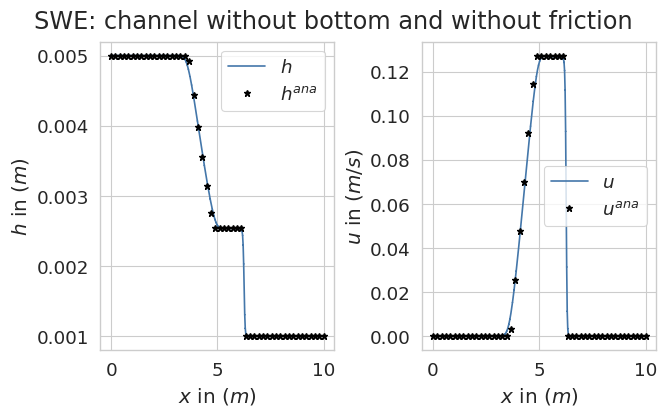

In [4]:
fig = plots_paper.plot_swe(os.path.join(settings.output.directory, settings.output.filename + ".h5"))